# Import of packages

In [1]:
'''To install the required packages that are not included in Colaboratory.'''
#Installation of packages that are not included in Colaboratory
!pip install kneed
!pip install osmnx

'''To install a specific version of the matplotlib package.'''
!pip install matplotlib==3.1.3

'''To import the required packages.'''
import pandas as pd
import numpy as np
import networkx as nx
import collections
import matplotlib.pyplot as plt
import math
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

from kneed import KneeLocator
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA

#import osmnx as ox

  Using cached matplotlib-3.3.4-cp38-cp38-macosx_10_9_x86_64.whl (8.5 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.1.3
    Uninstalling matplotlib-3.1.3:
      Successfully uninstalled matplotlib-3.1.3
  Using cached matplotlib-3.1.3-cp38-cp38-macosx_10_9_x86_64.whl (13.2 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.4
    Uninstalling matplotlib-3.3.4:
      Successfully uninstalled matplotlib-3.3.4
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

osmnx 1.0.1 requires matplotlib>=3.3, but you'll have matplotlib 3.1.3 which is incompatible.


# Settings

In [2]:
'''To display all output results of a Jupyter cell.'''
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
'''To ensure that the output results of extensive output results are not truncated.'''
#pd.options.display.max_rows = 4000

'To ensure that the output results of extensive output results are not truncated.'

# To import csv files

In [4]:
''' To import the df_for_edges dfs of Belgium and the Netherlands'''
datalink = "https://raw.githubusercontent.com/polkuleuven/Thesis_Train/main/df_for_edges/"
df_for_edges_Belgium = pd.read_csv( datalink + 'df_for_edges_Belgium.csv', sep=",")
df_for_edges_Netherlands = pd.read_csv(datalink + 'df_for_edges_Netherlands.csv', sep=",")
df_for_edges_Switzerland = pd.read_csv(datalink + 'df_for_edges_Switzerland.csv', sep=",")

' To import the df_for_edges dfs of Belgium and the Netherlands'

In [5]:
''' To import the stops_cleaned df for Belgium and the Netherlands'''
datalink = "https://raw.githubusercontent.com/polkuleuven/Thesis_Train/main/stops_cleaned/"
stops_cleaned_Belgium = pd.read_csv(datalink + 'stops_cleaned_Belgium.csv', sep=",")
stops_cleaned_Netherlands = pd.read_csv(datalink + 'stops_cleaned_Netherlands.csv', sep=",")
stops_cleaned_Switzerland = pd.read_csv(datalink + 'stops_cleaned_Switzerland.csv', sep=",")

' To import the stops_cleaned df for Belgium and the Netherlands'

In [6]:
''' To import the belgian_routes_Belgium and the dutch_routes_Netherlands csvs'''
datalink = "https://raw.githubusercontent.com/polkuleuven/Thesis_Train/main/routes/"
belgian_routes_Belgium = pd.read_csv(datalink + 'belgian_routes_Belgium.csv', sep=",")
dutch_routes_Netherlands = pd.read_csv(datalink + 'dutch_routes_Netherlands.csv', sep=",")
dutch_routes_Switzerland = pd.read_csv(datalink + 'swiss_routes_Switzerland.csv', sep=",")

' To import the belgian_routes_Belgium and the dutch_routes_Netherlands csvs'

# **Research question 1: How similar are railway systems in terms of their global network metrics? Comparison of the Belgian and the Dutch railway system in L-space representation**

In [7]:
''' To construct the network graph for the country '''
def create_graph(df_for_edges):
    G = nx.Graph()
    G = nx.from_pandas_edgelist(df_for_edges, 'stop_name_1', 'stop_name_2')
    return G

' To construct the network graph for the country '

In [8]:
''' To assign weights to the network graph for the country'''
def assign_weights (G, df_for_edges, stops_cleaned):
    # To assign node weights to graph
    for i in range(len(stops_cleaned)):
        for n, d in G.nodes(data=True):
            if stops_cleaned.stop_name[i] == n:
                G.nodes[n]['id']=stops_cleaned.stop_id[i]
                G.nodes[n]['latitude']=stops_cleaned.stop_lat[i]
                G.nodes[n]['longitude']=stops_cleaned.stop_lon[i]
                G.nodes[n]['country']=stops_cleaned.country[i]

    # To assign edge weights to the graph: the edge weight represents a list that contains all route_ids that cover that edge
    routes_on_edge = {}
    for node1,node2, edgeData in G.edges(data = True):
        if (node1, node2) not in routes_on_edge:
                routes_on_edge[(node1, node2)] = set()
        route_id_node1_node2= df_for_edges[(df_for_edges['stop_name_1'] == node1 ) & (df_for_edges['stop_name_2'] == node2 )]['route_id']
        route_id_node2_node1= df_for_edges[(df_for_edges['stop_name_1'] == node2 ) & (df_for_edges['stop_name_2'] == node1 )]['route_id']
        for route_id in pd.concat([route_id_node1_node2, route_id_node2_node1]):
            routes_on_edge[(node1, node2)].add(route_id)
        edgeData['route_id'] = routes_on_edge[(node1, node2)] 

    return G

' To assign weights to the network graph for the country'

In [9]:
'''Calculates number of nodes in the country railway system that consists of all routes that contain at least one node in the country'''
def number_country_stations(G, country):
    number_country_stations = 0
    for n, d in G.nodes(data=True):
        if G.nodes[n]['country']== country:
            number_country_stations += 1
    return number_country_stations

'Calculates number of nodes in the country railway system that consists of all routes that contain at least one node in the country'

In [10]:
'''Calculates the average degree'''
def avg_degree(G):
    sum_degrees = 0
    for n in G.nodes():
        sum_degrees += G.degree[n]
    return (sum_degrees/len(G.nodes()))

'Calculates the average degree'

In [11]:
'''Calculates the average degree considering only the stops of the country'''
def avg_degree_country(G, country):    
    sum_degrees = 0
    number_country_stations = 0
    for n, d in G.nodes(data=True):
        if G.nodes[n]['country']== country:
            number_country_stations += 1
            sum_degrees += G.degree[n]
    return(sum_degrees/number_country_stations)

'Calculates the average degree considering only the stops of the country'

In [12]:
'''Calculates the gamma index'''
def gamma_index(G):
    return len(G.edges()) / (3*(len(G.nodes()) - 2))

'Calculates the gamma index'

In [13]:
''' The degree distribution of the country railway system'''
def degree_distribution(G):

    #Sort degree values
    degree_sequence=sorted([d for n, d in G.degree()], reverse=True)

    #Count number of frequences of degree values
    degreeCount=collections.Counter(degree_sequence)

    #Define variables deg and cnt and probability
    deg, cnt = zip(*degreeCount.items())
    probability = []
    for v in cnt:
        pv= v/len(G.nodes())
        probability.append(pv)

    #plot degree probability histogram
    fig, ax = plt.subplots(figsize=(5, 5))
    plt.bar(deg, probability, width=0.95, color='lightgrey')

    #plot degree distribution
    plt.plot(deg, probability, color="b")

    #graph settings
    plt.title("Degree distribution")
    plt.ylabel("P (k)")
    plt.xlabel("k")
    ax.set_xticks([d for d in deg])
    ax.set_xticklabels(deg)

    #count
    fig, ax = plt.subplots(figsize=(5, 5))
    plt.bar(deg, cnt, width=0.95, color='lightgrey')

    plt.plot(deg, cnt, color="b")

    #graph settings
    plt.title("Degree count")
    plt.ylabel("Count")
    plt.xlabel("k")
    ax.set_xticks([d for d in deg])
    ax.set_xticklabels(deg)

    plt.show()

' The degree distribution of the country railway system'

## **Calculation of the global characteristics of the Belgian railway system in the L-space representation**

In [14]:
B = create_graph(df_for_edges_Belgium)
B = assign_weights (B, df_for_edges_Belgium, stops_cleaned_Belgium)

In [15]:
''' The number of nodes in the Belgian railway system '''
# The number of total nodes in the Belgian railway system that consists of all routes that contain at least one node in Belgium
len(B.nodes())

# The number of belgian nodes in the Belgian railway system that consists of all routes that contain at least one node in Belgium
number_country_stations(B, 'Belgium')

' The number of nodes in the Belgian railway system '

607

563

In [16]:
B.degree()

DegreeView({'TOURNAI': 3, 'FROYENNES': 3, 'HERSEAUX': 2, 'MOUSCRON': 3, 'BRUGES': 4, 'BRUGES-SAINT-PIERRE': 4, 'HEIST': 2, 'DUINBERGEN': 2, 'KNOKKE': 1, 'VERVIERS-CENTRAL': 2, 'PEPINSTER': 3, 'PEPINSTER-CITE': 2, 'JUSLENVILLE': 2, 'THEUX': 2, 'FRANCHIMONT': 2, 'SPA': 2, 'SPA-GERONSTERE': 1, 'GAND-SAINT-PIERRE': 7, 'DE PINTE': 3, 'DEINZE': 3, 'AARSELE': 2, 'TIELT': 2, 'LICHTERVELDE': 4, 'TORHOUT': 2, 'ZEDELGEM': 2, 'GRAMMONT': 4, 'SCHENDELBEKE': 2, 'IDEGEM': 2, 'ZANDBERGEN': 2, 'APPELTERRE': 2, 'EICHEM': 2, 'NINOVE': 2, 'OKEGEM': 2, 'IDDERGEM': 2, 'DENDERLEEUW': 5, 'LEUZE': 2, 'ATH': 4, 'LUTTRE': 3, 'COURCELLES-MOTTE': 2, 'ROUX': 2, 'MARCHIENNE-AU-PONT': 3, 'CHARLEROI-SUD': 5, 'ROCHEFORT-JEMELLE': 2, 'MARLOIE': 3, 'AYE': 2, 'HAVERSIN': 2, 'CHAPOIS': 2, 'LEIGNON': 2, 'CINEY': 2, 'NATOYE': 2, 'ASSESSE': 2, 'COURRIERE': 2, 'SART-BERNARD': 2, 'NANINNE': 2, 'DAVE-SAINT-MARTIN': 2, 'JAMBES-EST': 2, 'NAMUR': 5, 'RHISNES': 2, 'SAINT-DENIS-BOVESSE': 2, 'BEUZET': 2, 'LONZEE': 2, 'GEMBLOUX': 3, 'E

In [17]:
''' The average degree of the nodes in the Belgian railway system indicating the number of directions 
a commuter can take from that given station.'''
# The average degree of all the nodes in the Belgian railway system that consists of all routes that cover at least one belgian station
print(avg_degree(B))

# The average degree of all the nodes in the Belgian railway system if only the belgian stations are considered
print(avg_degree_country(B, 'Belgium'))

' The average degree of the nodes in the Belgian railway system indicating the number of directions \na commuter can take from that given station.'

2.2800658978583197
2.280639431616341


In [18]:
''' The number of edges in the Belgian railway system '''
len(B.edges())

' The number of edges in the Belgian railway system '

692

In [19]:
''' The gamma index of the Belgian railway system'''
print(gamma_index(B))

' The gamma index of the Belgian railway system'

0.38126721763085397


In [20]:
''' The mean local clustering coefficient of the Belgian railway system '''
#The mean local clustering coefficient indicates for a random station the estimation of the division of the number of neighbouring stations of a station that are connected 
# divided by the possible number of connections between the neighbours of that station
print ("mean local clustering:", nx.average_clustering(B))

' The mean local clustering coefficient of the Belgian railway system '

mean local clustering: 0.03707016029915536


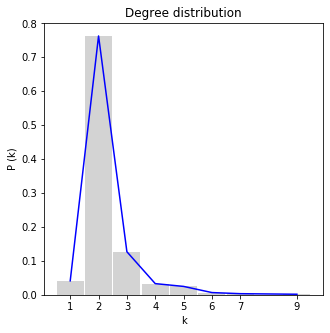

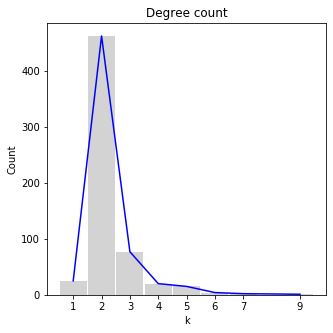

In [21]:
degree_distribution(B)

In [22]:
''' Detection of the scale-free property in the Belgian railway system:
A PTN with the scale-free property consists of a large number of vertices that exhibit low degree and a few number of vertices that exhibit very high degree. '''
print("The scale-free property is present in the Belgian railway network because the majority of nodes exhibit a low degree value equal to 2 and almost none of the nodes exhibit a degree value equal to 5 or higher")

' Detection of the scale-free property in the Belgian railway system:\nA PTN with the scale-free property consists of a large number of vertices that exhibit low degree and a few number of vertices that exhibit very high degree. '

The scale-free property is present in the Belgian railway network because the majority of nodes exhibit a low degree value equal to 2 and almost none of the nodes exhibit a degree value equal to 5 or higher


In [23]:
''' The average path length of the Belgian railway system:
The average path length represents in the L-space the average of all the shortest paths to be transversed between all public transport stop pairs
which can be reached by means of one or multiple routes.'''
print(nx.average_shortest_path_length(B))

' The average path length of the Belgian railway system:\nThe average path length represents in the L-space the average of all the shortest paths to be transversed between all public transport stop pairs\nwhich can be reached by means of one or multiple routes.'

21.72914457837876


In [24]:
''' The assortativity of the Belgian railway system:
In an assortative network, high-degree vertices tend to be connected and low-degree vertices tend to stick together as well. 
In a disassortative network conversely, high-degree and low-degree vertices tend to be connected to each other instead of being connected to vertices of the same kind.'''
print(nx.degree_pearson_correlation_coefficient(B))

' The assortativity of the Belgian railway system:\nIn an assortative network, high-degree vertices tend to be connected and low-degree vertices tend to stick together as well. \nIn a disassortative network conversely, high-degree and low-degree vertices tend to be connected to each other instead of being connected to vertices of the same kind.'

0.1928508437410642


## **Calculation of the global characteristics of the Dutch railway system in the L-space representation**

In [25]:
N = create_graph(df_for_edges_Netherlands)
N = assign_weights(N, df_for_edges_Netherlands, stops_cleaned_Netherlands)

In [26]:
N.edges(data=True)

EdgeDataView([('AMSTERDAM CENTRAAL', 'SCHIPHOL AIRPORT', {'route_id': {77633, 59426, 17795, 67402, 66765, 17615, 17522, 77621, 75065, 77595, 77628}}), ('AMSTERDAM CENTRAAL', 'AMSTERDAM SLOTERDIJK', {'route_id': {61920, 17792, 76993, 41226, 17803, 46093, 77614, 52990, 41202, 46036, 17748, 52984, 52986, 17661, 41214}}), ('AMSTERDAM CENTRAAL', 'HILVERSUM', {'route_id': {76452, 67431, 77591, 77592, 77593, 17725, 77630}}), ('AMSTERDAM CENTRAAL', 'AMSTERDAM MUIDERPOORT', {'route_id': {61920, 46084, 77609, 46092, 17748}}), ('AMSTERDAM CENTRAAL', 'AMSTERDAM AMSTEL', {'route_id': {17792, 77614, 52984, 52986, 52990}}), ('AMSTERDAM CENTRAAL', 'UTRECHT CENTRAAL', {'route_id': {77600, 77601, 77602, 77603, 77634, 77636, 75064, 77635, 67402, 66765, 77621, 34264, 34238}}), ('AMSTERDAM CENTRAAL', 'ALMERE CENTRUM', {'route_id': {45189, 44942}}), ('AMSTERDAM CENTRAAL', 'HAARLEM', {'route_id': {74608}}), ('AMSTERDAM CENTRAAL', 'ROTTERDAM CENTRAAL', {'route_id': {75060}}), ('AMSTERDAM CENTRAAL', 'HILVERSUM

In [27]:
''' The number of nodes in the Dutch railway system '''
# The number of total nodes in the Dutch railway system that consists of all routes that contain at least one node in the Netherlands
len(N.nodes())

# The number of dutch nodes in the Dutch railway system that consists of all routes that contain at least one node in the Netherlands
print(number_country_stations(N, 'Netherlands'))

' The number of nodes in the Dutch railway system '

519

394


In [28]:
''' The degrees of the nodes in the Dutch railway system '''
N.degree()

' The degrees of the nodes in the Dutch railway system '

DegreeView({'AMSTERDAM CENTRAAL': 12, 'SCHIPHOL AIRPORT': 9, 'ROTTERDAM CENTRAAL': 13, 'UTRECHT CENTRAAL': 18, 'GOUDA': 11, 'ROTTERDAM ALEXANDER': 4, 'LEIDEN CENTRAAL': 11, 'LEIDEN LAMMENSCHANS': 2, 'ALPHEN A/D RIJN': 3, 'BODEGRAVEN': 2, 'WOERDEN': 5, 'ALMERE OOSTVAARDERS': 2, 'ALMERE BUITEN': 4, 'ALMERE PARKWIJK': 2, 'ALMERE CENTRUM': 7, 'ALMERE MUZIEKWIJK': 2, 'ALMERE POORT': 3, 'WEESP': 4, 'DIEMEN ZUID': 2, 'DUIVENDRECHT': 7, 'AMSTERDAM RAI': 2, 'AMSTERDAM ZUID': 5, 'HOOFDDORP': 3, 'DEN HAAG CENTRAAL': 5, 'AMERSFOORT CENTRAAL': 10, 'AMERSFOORT SCHOTHORST': 2, 'GRONINGEN': 5, 'ASSEN': 4, 'ZWOLLE': 11, 'BREDA': 7, 'MEPPEL': 3, 'STEENWIJK': 3, 'WOLVEGA': 2, 'HEERENVEEN': 4, 'AKKRUM': 2, 'GROU-JIRNSUM': 2, 'LEEUWARDEN': 7, 'BAARN': 3, 'SOESTDIJK': 2, 'SOEST': 2, 'SOEST ZUID': 2, 'DEN DOLDER': 3, 'BILTHOVEN': 2, 'UTRECHT OVERVECHT': 4, 'WEZEP': 2, "HARDE ('T)": 2, 'NUNSPEET': 2, 'HARDERWIJK': 3, 'ERMELO': 2, 'PUTTEN': 2, 'NIJKERK': 4, 'AMERSFOORT VATHORST': 2, 'UTRECHT LEIDSCHE RIJN': 2,

In [29]:
''' The average degree of the nodes in the Dutch railway system indicating the number of directions 
a commuter can take from that given station.'''
# The average degree of all the nodes in the Dutch railway system that consists of all routes that cover at least one dutch station
print(avg_degree(N))

# The average degree of all the nodes in the Dutch railway system if only the dutch stations are considered
print(avg_degree_country(N, 'Netherlands'))

' The average degree of the nodes in the Dutch railway system indicating the number of directions \na commuter can take from that given station.'

2.6666666666666665
2.814720812182741


In [30]:
''' The number of edges in the Dutch railway system '''
len(N.edges())

' The number of edges in the Dutch railway system '

692

In [31]:
''' The gamma index of the Dutch railway system'''
print(gamma_index(N))

' The gamma index of the Dutch railway system'

0.44616376531270147


In [32]:
''' The mean local clustering coefficient of the Dutch railway system '''
#The mean local clustering coefficient indicates for a random station the estimation of the division of the number of neighbouring stations of a station that are connected 
# divided by the possible number of connections between the neighbours of that station
print ("mean local clustering:", nx.average_clustering(N))

' The mean local clustering coefficient of the Dutch railway system '

mean local clustering: 0.10406279151603876


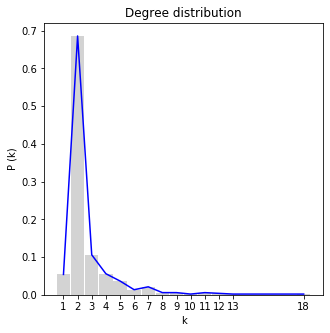

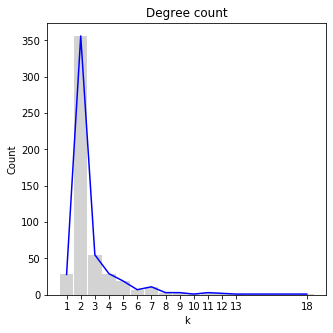

In [33]:
degree_distribution(N)

In [34]:
''' Detection of the scale-free property in the Dutch railway system:
A PTN with the scale-free property consists of a large number of vertices that exhibit low degree and a few number of vertices that exhibit very high degree. '''
print("The scale-free property is present in the Dutch railway network because the majority of nodes exhibit a low degree value equal to 2 and almost none of the nodes exhibit a degree value equal to 6 or higher")

' Detection of the scale-free property in the Dutch railway system:\nA PTN with the scale-free property consists of a large number of vertices that exhibit low degree and a few number of vertices that exhibit very high degree. '

The scale-free property is present in the Dutch railway network because the majority of nodes exhibit a low degree value equal to 2 and almost none of the nodes exhibit a degree value equal to 6 or higher


In [35]:
''' The average path length of the Dutch railway system:
The average path length represents in the L-space the average of all the shortest paths to be transversed between all public transport stop pairs
which can be reached by means of one or multiple routes.'''
print(nx.average_shortest_path_length(N))

' The average path length of the Dutch railway system:\nThe average path length represents in the L-space the average of all the shortest paths to be transversed between all public transport stop pairs\nwhich can be reached by means of one or multiple routes.'

9.916746639289991


In [36]:
''' The assortativity of the Dutch railway system:
In an assortative network, high-degree vertices tend to be connected and low-degree vertices tend to stick together as well. 
In a disassortative network conversely, high-degree and low-degree vertices tend to be connected to each other instead of being connected to vertices of the same kind.'''
print(nx.degree_pearson_correlation_coefficient(N))

' The assortativity of the Dutch railway system:\nIn an assortative network, high-degree vertices tend to be connected and low-degree vertices tend to stick together as well. \nIn a disassortative network conversely, high-degree and low-degree vertices tend to be connected to each other instead of being connected to vertices of the same kind.'

0.25607429056754694


## **Calculation of the global characteristics of the Swiss railway system in the L-space representation**

In [37]:
S = create_graph(df_for_edges_Switzerland)
S = assign_weights(S, df_for_edges_Switzerland, stops_cleaned_Switzerland)

In [38]:
S.edges(data=True)

EdgeDataView([('LES BRENETS', 'LES FRETES', {'route_id': {'00001.000044.018:1'}}), ('LES FRETES', 'LE LOCLE LE CHALET', {'route_id': {'00001.000044.018:1'}}), ('LE LOCLE LE CHALET', 'LE LOCLE', {'route_id': {'00001.000044.018:1'}}), ('LE LOCLE', 'LE CRET-DU-LOCLE', {'route_id': {'07237.000011.101:7237', '07205.000011.101:7205', '06350.000011.101:6350', '18101.000011.101:18101'}}), ('LE LOCLE', 'LA CHAUX-DE-FONDS', {'route_id': {'18102.000011.101:18102', '06365.000011.102:6365'}}), ('LE LOCLE', 'LE LOCLE-COL-DES-ROCHES', {'route_id': {'18102.000011.101:18102', '18101.000011.101:18101'}}), ('BRIENZ BRB', 'PLANALP', {'route_id': {'00001.000104.001:1', '00071.000104.001:71'}}), ('PLANALP', 'BRIENZER ROTHORN', {'route_id': {'00001.000104.001:1'}}), ('BASEL BAD BF', 'BASEL SBB', {'route_id': {'00006.000011.101:6', '00006.000011.102:6', '00003.000011.105:3', '00151.000011.101:151', '00273.000011.104:273', '05320.000011.105:5320', '00052.000011.101:52', '00373.000011.102:373', '05321.000011.10

In [39]:
''' The number of nodes in the Swiss railway system '''
# The number of total nodes in the Swiss railway system that consists of all routes that contain at least one node in the Netherlands
len(S.nodes())

# The number of swiss nodes in the Swiss railway system that consists of all routes that contain at least one node in the Netherlands
print(number_country_stations(S, 'Switzerland'))

' The number of nodes in the Swiss railway system '

1855

1656


In [40]:
''' The degrees of the nodes in the Swiss railway system '''
S.degree()

' The degrees of the nodes in the Swiss railway system '

DegreeView({'LES BRENETS': 1, 'LES FRETES': 2, 'LE LOCLE LE CHALET': 2, 'LE LOCLE': 4, 'BRIENZ BRB': 1, 'PLANALP': 2, 'BRIENZER ROTHORN': 1, 'BASEL BAD BF': 8, 'BASEL SBB': 15, 'HAUENSTEIN-BASISTUNNEL': 2, 'ZURICH HB': 25, 'ZIMMERBERG-BASISTUNNEL': 3, 'SARGANS': 9, 'LANDQUART': 11, 'CHUR': 15, 'TASCH': 2, 'ZERMATT': 2, 'STE-CROIX': 1, 'SIX-FONTAINES': 2, 'BAULMES': 2, 'VUITEBOEUF': 2, 'ESSERT-SOUS-CHAMPVENT': 2, 'VALEYRES-SOUS-MONTAGNY': 2, 'LA BRINAZ': 3, 'YVERDON-LES-BAINS': 10, 'YVERDON WILLIAM BARBEY': 2, 'ALPNACHSTAD PB': 1, 'AEMSIGEN': 2, 'PILATUS KULM': 1, 'BLONAY': 5, 'CHAMBY': 4, 'CHAMBY-MUSEE': 2, 'INTERLAKEN OST': 5, 'INTERLAKEN WEST': 2, 'SPIEZ': 8, 'THUN': 8, 'BERN': 26, 'BAHN-2000-STRECKE': 5, 'OLTEN': 27, 'LIESTAL': 8, 'AIGLE': 8, 'AIGLE-HOPITAL': 2, 'ST-TRIPHON-VILLAGE': 2, 'OLLON VD': 2, 'LES ARNOUX': 2, 'VILLY': 2, 'ST-TRIPHON-GARE': 2, 'PONT DU RHONE': 2, 'CORBIER': 2, 'COLLOMBEY-MURAZ': 2, 'MONTHEY-EN PLACE': 3, 'MONTHEY-VILLE': 1, 'MONTHEY-HOPITAL': 2, 'CHEMEX': 2,

In [41]:
''' The average degree of the nodes in the Swiss railway system indicating the number of directions 
a commuter can take from that given station.'''
# The average degree of all the nodes in the Swiss railway system that consists of all routes that cover at least one Swiss station
print(avg_degree(S))

# The average degree of all the nodes in the Swiss railway system if only the Swiss stations are considered
print(avg_degree_country(S, 'Switzerland'))

' The average degree of the nodes in the Swiss railway system indicating the number of directions \na commuter can take from that given station.'

2.739622641509434
2.7566425120772946


In [42]:
''' The number of edges in the Swiss railway system '''
len(S.edges())

' The number of edges in the Swiss railway system '

2541

In [43]:
''' The gamma index of the Swiss railway system'''
print(gamma_index(S))

' The gamma index of the Swiss railway system'

0.45709660010793307


In [44]:
''' The mean local clustering coefficient of the Swiss railway system '''
#The mean local clustering coefficient indicates for a random station the estimation of the division of the number of neighbouring stations of a station that are connected 
# divided by the possible number of connections between the neighbours of that station
print ("mean local clustering:", nx.average_clustering(S))

' The mean local clustering coefficient of the Swiss railway system '

mean local clustering: 0.1688267170643895


' The degree distribution of the Swiss railway system'

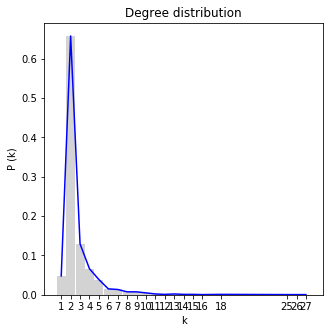

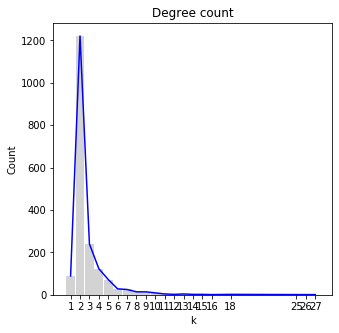

In [45]:
''' The degree distribution of the Swiss railway system'''
degree_distribution(S)

In [46]:
''' Detection of the scale-free property in the Swiss railway system:
A PTN with the scale-free property consists of a large number of vertices that exhibit low degree and a few number of vertices that exhibit very high degree. '''
print("The scale-free property is present in the Swiss railway network because the majority of nodes exhibit a low degree value equal to 2 and almost none of the nodes exhibit a degree value equal to 5 or higher")

' Detection of the scale-free property in the Swiss railway system:\nA PTN with the scale-free property consists of a large number of vertices that exhibit low degree and a few number of vertices that exhibit very high degree. '

The scale-free property is present in the Swiss railway network because the majority of nodes exhibit a low degree value equal to 2 and almost none of the nodes exhibit a degree value equal to 5 or higher


In [47]:
''' The average path length of the Swiss railway system:
The average path length represents in the L-space the average of all the shortest paths to be transversed between all public transport stop pairs
which can be reached by means of one or multiple routes.'''
#print(nx.average_shortest_path_length(S))

' The average path length of the Swiss railway system:\nThe average path length represents in the L-space the average of all the shortest paths to be transversed between all public transport stop pairs\nwhich can be reached by means of one or multiple routes.'

In [48]:
''' The assortativity of the Swiss railway system:
In an assortative network, high-degree vertices tend to be connected and low-degree vertices tend to stick together as well. 
In a disassortative network conversely, high-degree and low-degree vertices tend to be connected to each other instead of being connected to vertices of the same kind.'''
print(nx.degree_pearson_correlation_coefficient(S))

' The assortativity of the Swiss railway system:\nIn an assortative network, high-degree vertices tend to be connected and low-degree vertices tend to stick together as well. \nIn a disassortative network conversely, high-degree and low-degree vertices tend to be connected to each other instead of being connected to vertices of the same kind.'

0.2306904863891035


# RQ2: Clustering preparation

In [49]:
''' To put all the unique route_ids of the df_for_edges in df route_characteristics_Belgium'''
def create_route_characteristics(df_for_edges):
    # To create a list of all unique route_ids in the df_for_edges dataset
    routes_list = list(df_for_edges['route_id'].unique())
    routes_list.sort()

    # To create a dataframe that contains the values in the route_characteristics_Belgium_dic as the values in the first column'''
    route_characteristics = pd.DataFrame(routes_list, columns=['route_id'])
    return route_characteristics

' To put all the unique route_ids of the df_for_edges in df route_characteristics_Belgium'

In [50]:
''' To put the stations per route_id in df route_characteristics'''
def put_stations_route_characteristics(G, route_characteristics):
    # To construct a new column of the route_characteristics_Belgium dataset that has for every column value an empty set
    route_characteristics['nodes'] = [set() for _ in range(len(route_characteristics))]

    # To put the two nodes of an edge in the nodes column of the route_characteristics_Belgium dataset if the route_id of the corresponding row 
    # is present in the set of the list values of the corresponding edge that contains all route_ids that contain the edge
    for node1, node2 in G.edges():
        route_characteristics[['route_id','nodes']].apply(lambda x: x['nodes'].update((node1, node2)) if x['route_id'] in set(G.get_edge_data(node1, node2)['route_id']) else x, axis = 1)
    return route_characteristics

' To put the stations per route_id in df route_characteristics_Belgium'

In [79]:
#NEW
'''Deletes every empty route (useful after a inside contry filter)'''
def deletes_empty_routes(route_characteristics):
    index_empty_routes = route_characteristics_Belgium_belgian_nodes[route_characteristics_Belgium_belgian_nodes['nodes'].map(lambda d: len(d)) == 0].index
    return route_characteristics.drop(index_empty_routes)

'Deletes every empty route (useful after a inside contry filter)'

In [51]:
''' Definitions to calculate route topological metrics'''

# The inputs of the get_metric_list function are a dictionary that contains for all node keys the corresponding metric values and a specific route_id of a column of 
# the route_characteristics dataset
# A new empty list metric_list is created for these inputs
# For the nodes that are in the route_characteristics dataset corresponding to this route_id, the corresponding metric values from the dictionary get appended to metric_list

from statistics import mean
def get_metric_list(route_characteristics, metric_dic, route_id):
    """this is a sub function that is used in calculate_metric_route_per_node"""
    metric_list = []
    for nodes in route_characteristics[route_characteristics['route_id'] == route_id]['nodes']:
        for node in nodes:
            metric_list.append(metric_dic[node])
    return metric_list

# For the metric, a new column is created in route_characteristics, where every column value consists of an empty list
# The values in the column of the df are determined by giving the metric_dic and the route_id of the row where that value is placed to the get_metric_list function
# The metric_list ultimately contains the metric values for a specific metric for all the stations corresponding to that route

def calculate_metric_route_per_node(route_characteristics, metric_dic, metric_name):
    """puts the metrics of each node of a route in a list in the route_characteristics df"""
    route_characteristics[metric_name] = [list for _ in range(len(route_characteristics))]
    route_characteristics[metric_name] = route_characteristics.apply(lambda x: get_metric_list(route_characteristics, metric_dic, x['route_id']) , axis = 1)
    
# The function starts from the metric_name, the original_metric_name and the aggregation_method inputs
# A new column named with the metric_name is created: initially it contains all NaN values
# Thereafter the aggregation_method is taken into account. The avg aggregation method returns for all column values the mean of the values in the corresponding row
# of the original_metric_name list. The max aggregation method returns for all column values the max of the values in the corresponding row of the original_metric_name list.

def calculate_metric_aggregation_route(route_characteristics, metric_name, original_metric_name, aggregation_method):
    '''calculate the metric aggregation of the routes, only avg and max are supported as string values for aggregation method
    metric_name is the aggregation column name and original_metric_name is the node metric column name'''
    route_characteristics[metric_name] = np.nan
    if aggregation_method == 'avg':
        route_characteristics[metric_name] = route_characteristics.apply(lambda x: mean(x[original_metric_name]) , axis = 1)
    elif aggregation_method == 'max':
        route_characteristics[metric_name] = route_characteristics.apply(lambda x: max(x[original_metric_name]) , axis = 1)

' Definitions to calculate route topological metrics'

In [52]:
'''Calculate the metrics of the route_characteristics df'''
def calculate_characteristics (G, route_characteristics):
    calculate_metric_route_per_node(route_characteristics, dict(G.degree()), 'node_degree')
    calculate_metric_aggregation_route(route_characteristics, 'avg_degree', 'node_degree', 'avg')
    calculate_metric_aggregation_route(route_characteristics, 'max_degree', 'node_degree', 'max')
    calculate_metric_route_per_node(route_characteristics, dict(nx.clustering(G)), 'node_clustering')
    calculate_metric_aggregation_route(route_characteristics, 'avg_clustering', 'node_clustering', 'avg')
    calculate_metric_aggregation_route(route_characteristics, 'max_clustering', 'node_clustering', 'max')
    calculate_metric_route_per_node(route_characteristics, dict(nx.closeness_centrality(G)), 'node_closeness_centrality')
    calculate_metric_aggregation_route(route_characteristics, 'avg_closeness_centrality', 'node_closeness_centrality', 'avg')
    calculate_metric_aggregation_route(route_characteristics, 'max_closeness_centrality', 'node_closeness_centrality', 'max')
    calculate_metric_route_per_node(route_characteristics, dict(nx.betweenness_centrality(G)), 'node_betweenness_centrality')
    calculate_metric_aggregation_route(route_characteristics, 'avg_betweenness_centrality', 'node_betweenness_centrality', 'avg')
    calculate_metric_aggregation_route(route_characteristics, 'max_betweenness_centrality', 'node_betweenness_centrality', 'max')
    return route_characteristics

'Calculate the metrics of the route_characteristics df'

In [53]:
''' To add the number of stations present in the stop sequence of a route_id'''
def add_number_stations(route_characteristics):
    number_stations = []
    for number_stops in route_characteristics['nodes']:
        number_stations.append(len(number_stops))

    route_characteristics['len_stop_sequence'] = number_stations
    return route_characteristics

' To add the number of stations present in the stop sequence of a route_id'

In [54]:
''' To add the absolute distances between the starting and the ending station of all routes'''

# Remember that geographical locations that are located further away to the right of the Prime Meridian Greenwich instead of another location that is closer
# (but still to the right) of this Meridian Greenwich, have a greater longitute value.
# Remember that geographical locations that are higher above the Equator than other geographical locations (that are also above the Equator), have a 
# higher latitude value

def add_absolute_distance(route_characteristics, df_for_edges, stops_cleaned):

    absolute_distance = []
    for route in route_characteristics['route_id']:
        subdf_stop_sequence = df_for_edges[df_for_edges['route_id'] == route]
        number_of_rows = len(subdf_stop_sequence.index)

        # To get the starting station and the ending_station of the stop sequence of a route
        starting_station = subdf_stop_sequence['stop_name_1'].iloc[0]
        ending_station = subdf_stop_sequence['stop_name_2'].iloc[number_of_rows - 1]

        # The radius of the earth
        R = 6373.0

        # To convert the coordinates in radians 
        lat_starting_station = math.radians(stops_cleaned[stops_cleaned['stop_name'] == starting_station]['stop_lat'].iloc[0])
        lon_starting_station = math.radians(stops_cleaned[stops_cleaned['stop_name'] == starting_station]['stop_lon'].iloc[0])
        lat_ending_station = math.radians(stops_cleaned[stops_cleaned['stop_name'] == ending_station]['stop_lat'].iloc[0])
        lon_ending_station = math.radians(stops_cleaned[stops_cleaned['stop_name'] == ending_station]['stop_lon'].iloc[0])

        # To calculate the change in coordinates
        dlon = lon_ending_station - lon_starting_station
        dlat = lat_ending_station - lat_starting_station

        # To use the Haversine formula to get the distance in kilometers between the starting_station and the ending_station
        a = math.sin(dlat / 2)**2 + math.cos(lat_starting_station) * math.cos(lat_ending_station) * math.sin(dlon / 2)**2
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

        # To calculate the distance
        distance = R * c

        # To add the distance in the absolute_distance list
        absolute_distance.append(distance)

    # To add the absolute_distance list as a column to the route_characteristics dataset
    route_characteristics['absolute_distance'] = absolute_distance
    return route_characteristics

' To add the absolute distances between the starting and the ending station of all routes'

In [55]:
''' To calculate the relative distance of the stop sequence of the route by only taking the starting and the ending station into account'''

def add_relative_distance (route_characteristics):
    # The relative distance of a route is the distance of the route divided by the distance of the route with the longest distance
    relative_distance = []

    # To calculate the route which stop sequence has the greatest absolute distance
    max_distance = route_characteristics['absolute_distance'].max()

    # To calculate the relative distance of each route
    for abs_distance in route_characteristics['absolute_distance']:
        rel_distance = abs_distance / max_distance
        relative_distance.append(rel_distance)

    # To add the relative_distance list as a column to the route_characteristics dataset
    route_characteristics['relative_distance'] = relative_distance
    return route_characteristics

' To calculate the relative distance of the stop sequence of the route by only taking the starting and the ending station into account'

## Clustering preparation Belgium

In [86]:
#New
belgian_stops = [n for n,v in B.nodes(data=True) if v['country'] == 'Belgium']
B_belgian_stops = B.subgraph(belgian_stops)

In [87]:
#NEW
route_characteristics_Belgium_belgian_nodes = create_route_characteristics(df_for_edges_Belgium)
route_characteristics_Belgium_belgian_nodes = put_stations_route_characteristics(B_belgian_stops, route_characteristics_Belgium_belgian_nodes)
route_characteristics_Belgium_belgian_nodes = deletes_empty_routes(route_characteristics_Belgium_belgian_nodes)
route_characteristics_Belgium_belgian_nodes = calculate_characteristics(B_belgian_stops, route_characteristics_Belgium_belgian_nodes)
route_characteristics_Belgium_belgian_nodes = add_number_stations(route_characteristics_Belgium_belgian_nodes)
route_characteristics_Belgium_belgian_nodes = add_absolute_distance(route_characteristics_Belgium_belgian_nodes, df_for_edges_Belgium, stops_cleaned_Belgium)
route_characteristics_Belgium_belgian_nodes = add_relative_distance (route_characteristics_Belgium_belgian_nodes)

In [63]:
route_characteristics_Belgium = create_route_characteristics(df_for_edges_Belgium)
route_characteristics_Belgium = put_stations_route_characteristics(B, route_characteristics_Belgium)
route_characteristics_Belgium = calculate_characteristics(B, route_characteristics_Belgium)
route_characteristics_Belgium = add_number_stations(route_characteristics_Belgium)
route_characteristics_Belgium = add_absolute_distance(route_characteristics_Belgium, df_for_edges_Belgium, stops_cleaned_Belgium)
route_characteristics_Belgium = add_relative_distance (route_characteristics_Belgium)

In [89]:
route_characteristics_Belgium

route_id                                              nodes  \
0         115           {MOUSCRON, HERSEAUX, TOURNAI, FROYENNES}   
1         116  {HEIST, BRUGES, KNOKKE, BRUGES-SAINT-PIERRE, D...   
2         117  {PEPINSTER, VERVIERS-CENTRAL, FRANCHIMONT, PEP...   
3         118  {TIELT, HEIST, BRUGES, TORHOUT, AARSELE, DE PI...   
4         119  {ZANDBERGEN, IDEGEM, GRAMMONT, NINOVE, APPELTE...   
..        ...                                                ...   
543       784  {BRUXELLES-MIDI, BRUXELLES-CONGRES, DE PINTE, ...   
544       785  {GRAMMONT, NINOVE, KWATRECHT, APPELTERRE, SCHE...   
545       786  {BOUWEL, KESSEL, MALINES-NEKKERSPOEL, SINT-JOR...   
546       787  {BRUXELLES-MIDI, BRUXELLES-CONGRES, ANDERLECHT...   
547       788  {NOORDERKEMPEN (BRECHT), BOOISCHOT, ANVERS-CEN...   

                                           node_degree  avg_degree  \
0                                         [3, 2, 3, 3]    2.750000   
1                                      [2, 4, 1, 4, 2]    2.600000   
2                             [3, 2, 2, 2, 1, 2, 2, 2]    2.000000   
3              [2, 2, 4, 2, 2, 3, 1, 4, 4, 7, 3, 2, 2]    2.923077   
4                       [2, 2, 4, 2, 2, 2, 2, 2, 5, 2]    2.500000   
..                                                 ...         ...   
543  [9, 2, 3, 2, 2, 7, 2, 3, 7, 2, 2, 4, 4, 3, 3, ...    3.500000   
544  [4, 2, 2, 2, 2, 2, 2, 3, 7, 2, 2, 2, 3, 2, 3, ...    2.800000   
545  [2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 6, 5, 3, ...    2.869565   
546  [9, 2, 4, 7, 2, 4, 3, 2, 4, 2, 3, 6, 2, 7, 3, ...    3.764706   
547  [2, 2, 2, 2, 5, 3, 2, 2, 3, 3, 2, 2, 7, 3, 2, ...    2.925926   

     max_degree                                    node_clustering  \
0             3                                       [0, 0, 0, 0]   
1             4                                    [0, 0, 0, 0, 0]   
2             3                           [0, 0, 0, 0, 0, 0, 0, 0]   
3             7  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0952380952380952...   
4             5                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
..          ...                                                ...   
543           9  [0.1111111111111111, 0, 0, 0, 0, 0.09523809523...   
544           7  [0, 0, 0, 0, 0, 0, 0, 0.3333333333333333, 0.09...   
545           6  [0, 0, 0.3333333333333333, 0, 0, 0, 0.33333333...   
546           9  [0.1111111111111111, 0, 0.3333333333333333, 0....   
547           7  [0, 0, 0, 0, 0.1, 0.3333333333333333, 0, 0, 0....   

     avg_clustering  max_clustering  \
0          0.000000        0.000000   
1          0.000000        0.000000   
2          0.000000        0.000000   
3          0.007326        0.095238   
4          0.000000        0.000000   
..              ...             ...   
543        0.058399        0.333333   
544        0.026429        0.333333   
545        0.072464        0.333333   
546        0.129505        0.333333   
547        0.175132        1.000000   

                             node_closeness_centrality  \
0    [0.05046635576282479, 0.04906485304833617, 0.0...   
1    [0.04135389654701788, 0.0450155994651612, 0.03...   
2    [0.04354073861186952, 0.04176717899234958, 0.0...   
3    [0.0536663124335813, 0.04135389654701788, 0.04...   
4    [0.046508058326937836, 0.045629094194714254, 0...   
..                                                 ...   
543  [0.06845137241613013, 0.06800583548423297, 0.0...   
544  [0.049485546300832926, 0.052695652173913046, 0...   
545  [0.050090924119689205, 0.055241567912488604, 0...   
546  [0.06845137241613013, 0.06800583548423297, 0.0...   
547  [0.0460871549167237, 0.055231498359460444, 0.0...   

     avg_closeness_centrality  max_closeness_centrality  \
0                    0.050689                  0.052641   
1                    0.041483                  0.045016   
2                    0.039166                  0.043541   
3                    0.050232                  0.065698   
4                    0.051603                

## Clustering preparation the Netherlands

In [ ]:
route_characteristics_Netherlands = create_route_characteristics(df_for_edges_Netherlands)
route_characteristics_Netherlands = put_stations_route_characteristics(N, route_characteristics_Netherlands)
route_characteristics_Netherlands = calculate_characteristics(N, route_characteristics_Netherlands)
route_characteristics_Netherlands = add_number_stations(route_characteristics_Netherlands)


In [ ]:
route_characteristics_Netherlands = add_absolute_distance(route_characteristics_Netherlands, df_for_edges_Netherlands, stops_cleaned_Netherlands)
route_characteristics_Netherlands = add_relative_distance (route_characteristics_Netherlands)

In [ ]:
route_characteristics_Netherlands

## Clustering preparation the Switzerland

In [ ]:
route_characteristics_Switzerland = create_route_characteristics(df_for_edges_Switzerland)
route_characteristics_Switzerland = put_stations_route_characteristics(S, route_characteristics_Switzerland)
route_characteristics_Switzerland = calculate_characteristics(S, route_characteristics_Switzerland)
route_characteristics_Switzerland = add_number_stations(route_characteristics_Switzerland)


In [ ]:
route_characteristics_Switzerland = add_absolute_distance(route_characteristics_Switzerland, df_for_edges_Switzerland, stops_cleaned_Switzerland)
route_characteristics_Switzerland = add_relative_distance (route_characteristics_Switzerland)

In [ ]:
route_characteristics_Switzerland